In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from numpy import array
import tensorflow as tf 
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = Tokenizer(oov_token="<OOV>")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.options.display.max_colwidth = 120

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### EDA

In [4]:
print("taille des datasets")
print(f" train : {data.shape}")
print(f" test : {test.shape}")

taille des datasets
 train : (7613, 5)
 test : (3263, 4)


In [5]:
print("Train set : pas de valeur Nan :")
print(data.isnull().sum())

print('')

print("Test set : pas de valeur Nan :")
print(test.isnull().sum())

Train set : pas de valeur Nan :
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test set : pas de valeur Nan :
id             0
keyword       26
location    1105
text           0
dtype: int64


In [6]:
print("Nombre de tweets Non Disaster -0- et Disaster -1- :")
data.target.value_counts()

Nombre de tweets Non Disaster -0- et Disaster -1- :


0    4342
1    3271
Name: target, dtype: int64

Non Disaster -0- et Disaster -1- :


/Users/berrehailmalika/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Nombre de tweets')

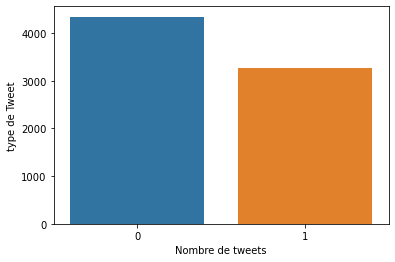

In [7]:
print('Non Disaster -0- et Disaster -1- :')

sns.countplot(data['target'])

plt.ylabel("type de Tweet")
plt.xlabel("Nombre de tweets")

In [8]:
print("les mots les plus utilisés :")
data.groupby('keyword').size().sort_values(ascending=False)

les mots les plus utilisés :


keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Length: 221, dtype: int64

In [9]:
data = data[['id','text','target']]
data.columns = ['id','text','target']

test = test[['id','text']]
test.columns = ['id','text']

### Data clean

In [10]:
nlp = spacy.load("en_core_web_sm")


In [11]:
# exemple twitt

twitts = data.sample(5)
for t in twitts.values:
    print(t)

[340
 'ANNIHILATED IN DAMASCUS: SYRIAN ARMY GRINDS \x89Û÷ALLOOSH AND HIS GANG INTO THE MANURE PILE\nhttp://t.co/7rakhP3bWm'
 1]
[7456
 "I need an arcade shooter fix but CTE is empty &amp; only running obliteration. I'd even buy a CoD title if they weren't all overpriced on steam"
 0]
[7513
 'Plains All American Pipeline company may have spilled 40% more crude oil than previously estimated #KSBYNews @lilitan http://t.co/PegibIqk2w'
 1]
[9491
 'Cross-border terrorism: Pakistan caught red-handed again - The Times of India http://t.co/uiqsfgZoOx'
 1]
[9281 "@bonhomme37 wouldn't that have sunk the sub?" 0]


In [12]:
def clean_remove(text):
    #clean_text = re.sub(r'http?://[\w\./]+\s*', '', text, flags=re.MULTILINE)
    #clean_text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',text, flags=re.MULTILINE)
    url_reg  = r'[a-z]*[:.]+\S+'
    clean_text = re.sub(url_reg, '', text)
    return clean_text

In [13]:
def remove_coma(text):
    '''
    Supprimez les virgules des nombres int
    '''
    clean_text = text
    matches = re.findall('\d+[,]\d*', text)#pattern to identify numbers with comas
    for match in matches:
        new_text = re.sub(r'[,.]+', '', match, flags=re.MULTILINE)
        clean_text = re.sub(match, new_text, clean_text)
    return clean_text

In [14]:
def isolate_number(text):
    '''
    Mettez des espaces avant et après un nombre. => 236.00end devient 236.00 end
    To isolate, first it finds the pattern and creates a group of words.  For ex. (236.00, end)
    '''
    clean_text = text
    #pattern (\d+[.]+\d*)([A-Za-z]+) identifes numbers attached to letters and separate them in groups.
    matches = re.findall('(\d+[.]+\d*)([A-Za-z]+)', text)
    for match in matches:
        #print(type(match),match)
        unsplit_match= ''.join(match)
        new_text = ' '.join(match)
        clean_text = re.sub(unsplit_match, new_text, clean_text)
    return clean_text

In [15]:
data["text_clean"] = data["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
data['text_clean'] = data['text_clean'].apply(lambda x: clean_remove(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_coma(x))
data['text_clean'] = data['text_clean'].apply(lambda x: isolate_number(x))
data["text_clean"] = data["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
data["text_clean"] = data["text_clean"].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
#data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS]))



test["text_clean"] = test["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
test['text_clean'] = test['text_clean'].apply(lambda x: clean_remove(x))
test['text_clean'] = test['text_clean'].apply(lambda x: remove_coma(x))
test['text_clean'] = test['text_clean'].apply(lambda x: isolate_number(x))
test["text_clean"] = test["text_clean"].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
test["text_clean"] = test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
#test["text_clean"] = test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS]))

#data = data[['id','text_clean','target']]


In [16]:
data.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place or...,1,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place order...
3,6,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders in california
4,7,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,just got sent this photo from ruby alaska as smoke from wildfires pours into a school


In [17]:
# Lemmatisation : convertir un mot à sa forme racine.

def lemmatization(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [18]:
data['text_wordcloud'] = data['text_clean'].apply(lambda x: lemmatization(x))
test['text_wordcloud'] = test['text_clean'].apply(lambda x: lemmatization(x))


In [19]:
data.head(2)

,id,text,target,text_clean,text_wordcloud
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,our deed be the reason of this earthquake may allah forgive we all
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada


In [20]:
def wordcloud(df, column, title):
    words = ' '.join(df[column].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords=stopwords, width=512, height=512).generate(words)
    plt.figure(figsize=(50,8), frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

### Visualisation data

Importance mots : Disaster Tweets



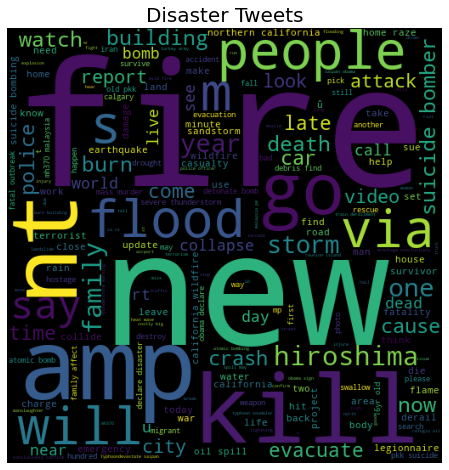

In [21]:
print("Importance mots : Disaster Tweets")
print('')
wordcloud(data[data["target"]==1], "text_wordcloud", "Disaster Tweets")

Importance mots : No Disaster Tweets



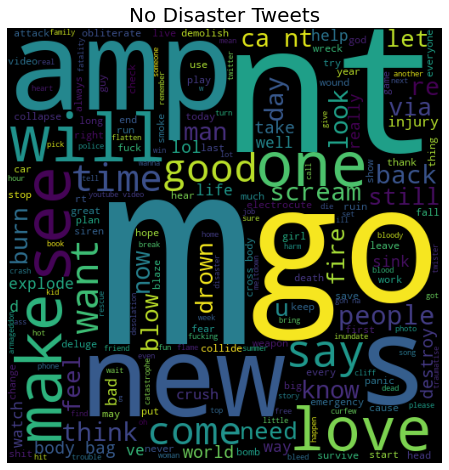

In [22]:
print("Importance mots : No Disaster Tweets")
print('')
wordcloud(data[data["target"]==0], "text_wordcloud", "No Disaster Tweets")

In [23]:
# create a TF-IDF matrix using sklearn

vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
X = vectorizer.fit_transform(data['text_clean'])
dense = X.toarray()


In [24]:
len(vectorizer.vocabulary_)

22552

In [25]:
data_tdif = pd.DataFrame(dense, columns=[x for x in vectorizer.get_feature_names()])

In [26]:
word_count = list()
words = data_tdif.columns.to_list()
word_count = [(data_tdif[c] !=0.0).sum() for c in data_tdif.columns]

data_counts_word = pd.DataFrame(zip(words,word_count), columns=['word', 'count'])

data_counts_word = pd.DataFrame(zip(words,word_count), columns=['word', 'count'])


### Data Preparation

In [27]:
tweets = data['text_wordcloud'] 
target = data['target']

vocab_size = 5000 

embedding_dim = 100

max_length = 100

trunc_type='post'

padding_type='post'

oov_tok = "<OOV>"

training_size = 20000

X_train, X_test, y_train, y_test = train_test_split(tweets, target, 
random_state=3, test_size=0.2)

In [28]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

text_index = tokenizer.word_index

data_sequences = tokenizer.texts_to_sequences(X_train)

data_padded = pad_sequences(data_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)

test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

tst_sequences = tokenizer.texts_to_sequences(test["text_clean"])

tst_padded = pad_sequences(tst_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_data = np.array(data_padded)

training_labels = np.array(y_train)

eval_data = np.array(test_padded)

eval_labels = np.array(y_test)

tst_data = tst_padded

tst_labels = np.array(test["id"])

### Data NLP Preprocessing & Model

In [29]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 502,449
Trainable params: 502,449
Non-trainable params: 0
_________________________________________________________________


In [31]:

#stopping which stop training when a monitored metric has stopped improving

stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lrr = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.5, min_lr=0.00001)

num_epochs = 15

history = model.fit(
    training_data, training_labels,
    epochs=num_epochs,
    batch_size = 32,
    validation_data=(eval_data, eval_labels), 
    verbose=2, callbacks=[stopping, lrr])

Epoch 1/15
191/191 - 2s - loss: 0.6783 - accuracy: 0.5742 - val_loss: 0.6746 - val_accuracy: 0.5522
Epoch 2/15
191/191 - 1s - loss: 0.6141 - accuracy: 0.6721 - val_loss: 0.5503 - val_accuracy: 0.7669
Epoch 3/15
191/191 - 1s - loss: 0.4648 - accuracy: 0.8089 - val_loss: 0.4806 - val_accuracy: 0.7932
Epoch 4/15
191/191 - 1s - loss: 0.3815 - accuracy: 0.8463 - val_loss: 0.4935 - val_accuracy: 0.7846
Epoch 5/15
191/191 - 1s - loss: 0.3339 - accuracy: 0.8609 - val_loss: 0.4577 - val_accuracy: 0.7978
Epoch 6/15
191/191 - 1s - loss: 0.3005 - accuracy: 0.8790 - val_loss: 0.4650 - val_accuracy: 0.7997
Epoch 7/15
191/191 - 1s - loss: 0.2733 - accuracy: 0.8900 - val_loss: 0.4759 - val_accuracy: 0.8030
Epoch 8/15
191/191 - 1s - loss: 0.2495 - accuracy: 0.8984 - val_loss: 0.4910 - val_accuracy: 0.8011

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


<Figure size 432x288 with 0 Axes>

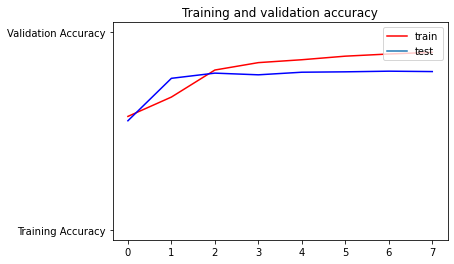

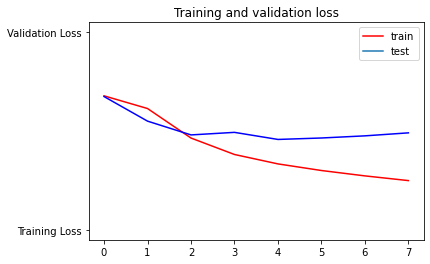

<Figure size 432x288 with 0 Axes>

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')

plt.title('Training and validation accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Training and validation loss')
plt.figure()

In [33]:
predictions = model.predict(tst_data)

predictions = np.around(predictions)

predictions = predictions.astype(int)

predictions_tweets = pd.DataFrame()

predictions_tweets["id"] = test["id"]

predictions_tweets["target"] = predictions

predictions_tweets['target'] = predictions_tweets['target'].replace([0,1],['Non Disaster','Disaster'])


In [34]:
predictions_tweets["target"].value_counts()

Non Disaster    2072
Disaster        1191
Name: target, dtype: int64

In [35]:
print("exemple de tweet 'Disaster' : ")

Disaster_id = predictions_tweets[predictions_tweets.target == "Disaster"].sample(1)

Disaster = test[test.id == int(Disaster_id.id)]

print("")

print(Disaster['text_wordcloud'].to_string(index=False))

exemple de tweet 'Disaster' : 

 wowo 12000 nigerian refugee repatriate from cameroon


In [36]:
print("exemple de tweet 'Non Disaster' :")

No_Disaster_id = predictions_tweets[predictions_tweets.target == "Non Disaster"].sample(1)
NO_Disaster = test[test.id == int(No_Disaster_id.id)]
print("")

print(NO_Disaster['text_wordcloud'].to_string(index=False))


exemple de tweet 'Non Disaster' :

 I m fall to piece and I wo nt be whole until you let I in   heroine by sleep with siren ûó httpstcotqxlqukq7z
